In [1]:
import cv2
import numpy as np
from glob import glob
from collections import Counter
from random import shuffle, choices

%matplotlib inline
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import inception_resnet_v2
from tensorflow.keras.utils import to_categorical

print(tf.__version__)
print(tf.executing_eagerly())

2.14.0
True


In [2]:
train_files = glob('drive/MyDrive/train/*/*.jpg')
test_files = glob('drive/MyDrive/test/*.jpg')
test_files += glob('drive/MyDrive/test/*/*.jpg')

classes = Counter([path.split('/')[-2] for path in train_files])
classes = {key: i for i, key in enumerate(classes.keys())}
classes

{'ALB': 0,
 'YFT': 1,
 'SHARK': 2,
 'OTHER': 3,
 'LAG': 4,
 'NoF': 5,
 'DOL': 6,
 'BET': 7}

In [3]:
IMG_SIZE = (1200, 750)  # размер входного изображения сети

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return inception_resnet_v2.preprocess_input(img)

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(len(files), batch_size)
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            X = np.array([load_image(path) for path in files[i:j]])
            y = to_categorical([classes[path.split('/')[-2]] for path in files[i:j]], 8)
            yield (X, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

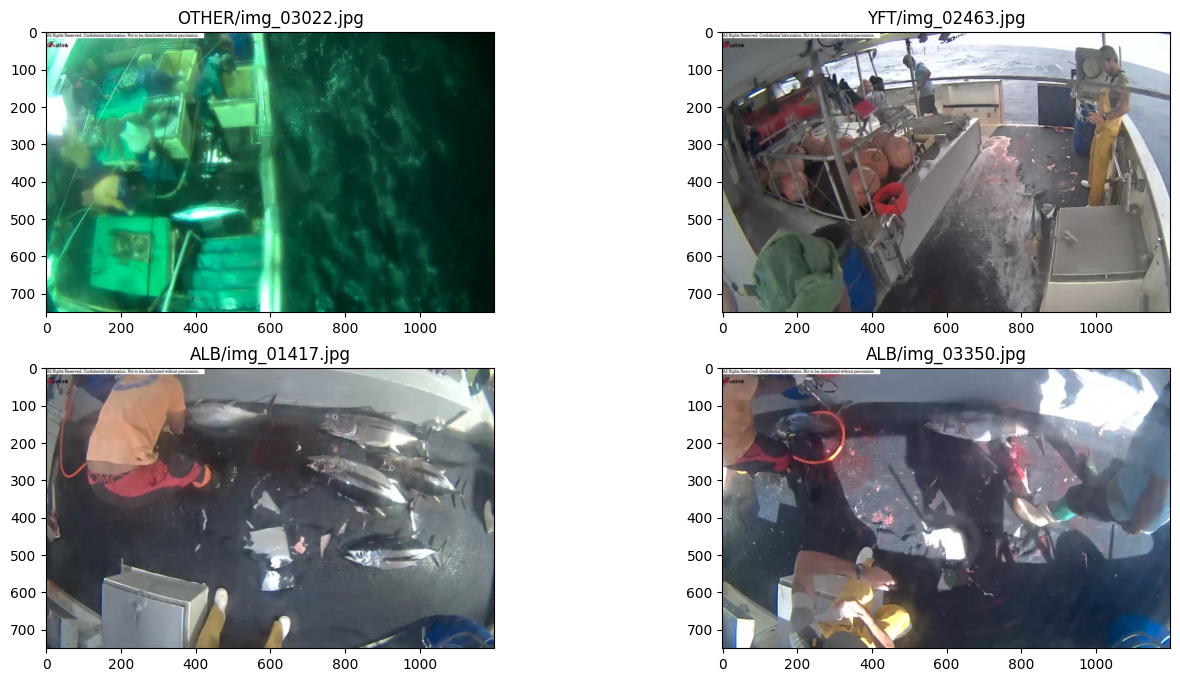

In [4]:
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(choices(train_files, k=4), 1):
    subplot = fig.add_subplot(2, 2, i)
    subplot.set_title('%s' % path.split('/', 3)[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

In [5]:
# base_model - объект класса keras.models.Model (Functional Model)
base_model = inception_resnet_v2.InceptionResNetV2(weights='imagenet',
                                                   include_top=False,
                                                   input_shape=(IMG_SIZE[1], IMG_SIZE[0], 3))

219055592/219055592 [==============================] - 1s 0us/step


In [6]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-1].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(8, activation='softmax', kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x)

In [7]:
model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=20)]

val_samples = 32  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=10,
          epochs=100,
          validation_data=validation_data,
        #   callbacks=callbacks
          )

Epoch 1/100
10/10 [==============================] - 249s 23s/step - loss: 81.3778 - accuracy: 0.3688 - val_loss: 47.7802 - val_accuracy: 0.3750
Epoch 2/100
10/10 [==============================] - 235s 24s/step - loss: 22.8612 - accuracy: 0.6500 - val_loss: 14.9759 - val_accuracy: 0.6562
Epoch 3/100
10/10 [==============================] - 223s 23s/step - loss: 13.2099 - accuracy: 0.7937 - val_loss: 26.5762 - val_accuracy: 0.6250
Epoch 4/100
10/10 [==============================] - 233s 24s/step - loss: 10.8765 - accuracy: 0.8281 - val_loss: 14.4087 - val_accuracy: 0.8125
Epoch 5/100
10/10 [==============================] - 234s 24s/step - loss: 13.2693 - accuracy: 0.8313 - val_loss: 12.8722 - val_accuracy: 0.8125
Epoch 6/100
10/10 [==============================] - 232s 24s/step - loss: 9.2483 - accuracy: 0.8750 - val_loss: 17.9709 - val_accuracy: 0.8438
Epoch 7/100
10/10 [==============================] - 232s 23s/step - loss: 8.4134 - accuracy: 0.8906 - val_loss: 19.3396 - val_accu

In [9]:
test_pred = model.predict(predict_generator(test_files), steps=len(test_files))

13153/13153 [==============================] - 7313s 556ms/step


In [10]:
with open('submit_3.csv', 'w') as dst:
    dst.write('image,'+','.join(classes.keys())+'\n')
    for path, probas in zip(test_files, test_pred):
        probas = ','.join([f'{x:f}' for x in probas.round(6)])
        dst.write(f'{path[19:]},{probas}\n')

!cp submit_3.csv 'drive/My Drive/'

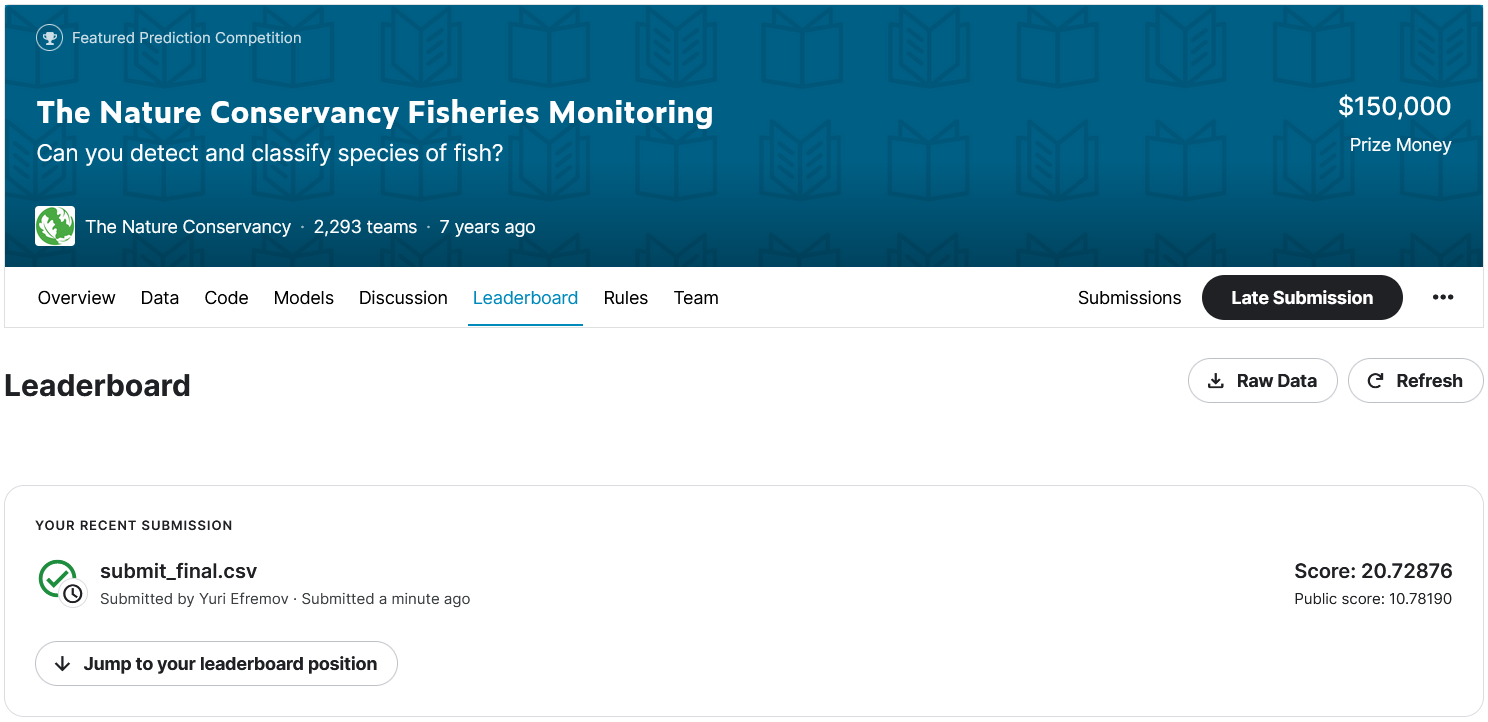